# Analyzing the dataset

In [1]:
from collections import Counter
from itertools import chain
from nltk.tokenize import word_tokenize
from statistics import mean, variance
from wordcloud import WordCloud, STOPWORDS

import contractions
import emoji
import matplotlib.pyplot as plt
import pandas
import re
import string

## Getting the Data

In [2]:
data = pandas.read_csv("../data/train-balanced-sarcasm.csv", index_col=False)

In [3]:
data.dropna(inplace = True)
data['label'] = data['label'].astype('int64')
data['comment'] = data['comment'].astype('string')
data['parent_comment'] = data['parent_comment'].astype('string')

In [4]:
display(data)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
...,...,...,...,...,...,...,...,...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
1010822,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
1010823,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
1010824,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...


In [5]:
print("Data was collected from %d users and %d subreddits." % (data["author"].nunique(), data["subreddit"].nunique()))

Data was collected from 256560 users and 14876 subreddits.


### Drop the columns we will not work on

In [6]:
data.drop(columns=["author", "subreddit", "score", "ups", "downs", "date", "created_utc"], inplace=True)

In [7]:
data.dtypes

label              int64
comment           string
parent_comment    string
dtype: object

## Lowercase and clean from punctuations, and filter long text

In [8]:
punc_inplace = {
    ':)' : ' SMILEY ',
    ':D' : ' GRINNINGFACE ',
    ':(' : ' SADFACE ',
    ':/' : ' CONFUSEDFACE ',
    '\n' : ' NEWLINE ',
    '.' : ' PERIOD ',
    ',' : ' COMMA ',
    '"' : ' QUOTATIONMARK ',
    ';' : ' SEMICOLON ',
    '!' : ' EXCLAMATIONMARK ',
    '?' : ' QUESTIONMARK ',
    '(' : ' LEFTPAREN ',
    ')' : ' RIGHTPAREN ',
    '/' : ' SLASH ',
    '-' : ' MINUSSIGN ',
    '?' : ' QUESTIONMARK ',
    ':' : ' COLON ',
    '#' : ' HASHTAG ',
    '%' : ' PERCENT ',
    '&' : ' AMPERSAND ',
    '=' : ' EQUALS ',
    '$' : ' DOLLARSIGN '
}

In [9]:
def clean_text(text):
    
    # Drop if text is too long
    if len(text) > 500:
        return None
        
    text = contractions.fix(text)
    text = text.lower()
    
    for key, value in punc_inplace.items():
        text = text.replace(key, value)
    
    text = emoji.demojize(text)
    
    text = re.sub(r'[^\w\s]', '', text)
    
    tokens = word_tokenize(text)
    text = " ".join([token for token in tokens])
    
    # Drop row if the comment is empty or too long after cleaning
    if (text.strip() == "") or (len(text) > 500):
        return None

    return text

In [10]:
data['comment'] = data['comment'].apply(clean_text)
print("[COMMENTS CLEANED]")

data['parent_comment'] = data['parent_comment'].apply(clean_text)
print("[PARENT COMMENTS CLEANED]")


data = data.dropna(subset=['label'])
data = data.dropna(subset=['comment'])
data = data.dropna(subset=['parent_comment'])

data = data.reset_index(drop=True)

[COMMENTS CLEANED]
[PARENT COMMENTS CLEANED]


In [11]:
display(data)

,label,comment,parent_comment
0,0,nc and nh PERIOD,yeah COMMA i get that argument PERIOD at this ...
1,0,you do know west teams play against west teams...,the blazers and mavericks LEFTPAREN the wests ...
2,0,they were underdogs earlier today COMMA but si...,they are favored to win PERIOD
3,0,this meme is not funny none of the QUOTATIONMA...,deadass do not kill my buzz
4,0,i could use one of those tools PERIOD,yep can confirm i saw the tool they use for th...
...,...,...,...
959600,1,i am sure that iran and n PERIOD korea have th...,no one is calling this an engineered pathogen ...
959601,1,whatever you do COMMA do not vote green EXCLAM...,in a move typical of their recent do MINUSSIGN...
959602,1,perhaps this is an atheist conspiracy to make ...,screw the disabled MINUSSIGN MINUSSIGN i have ...
959603,1,the slavs got their own country MINUSSIGN it i...,i have always been unsettled by that PERIOD i ...


In [12]:
data["label"].value_counts()

1    481058
0    478547
Name: label, dtype: int64

## Stats

In [13]:
data['comment_length'] = data.apply(lambda row: len(row['comment']), axis=1)
data['parent_length'] = data.apply(lambda row: len(row['parent_comment']), axis=1)

print("PARENT COMMENTS: [Average length: %.2f] [Variance: %.2f]" % (data['parent_length'].mean(), data['parent_length'].var()))
print("COMMENTS: [Average length: %.2f] [Variance: %.2f]" % (data['comment_length'].mean(), data['comment_length'].var()))

PARENT COMMENTS: [Average length: 119.46] [Variance: 9656.17]
COMMENTS: [Average length: 67.27] [Variance: 2272.18]


In [14]:
sarcastic_df = data[data['label'] == 1]
non_sarcastic_df = data[data['label'] == 0]

print("SARCASTIC COMMENTS: [Average length: %.2f] [Variance: %.2f]" % ( sarcastic_df['comment_length'].mean(), sarcastic_df['comment_length'].var() ))
print("NON-SARCASTIC COMMENTS: [Average length: %.2f] [Variance: %.2f]" % ( non_sarcastic_df['comment_length'].mean(), non_sarcastic_df['comment_length'].var() ))

SARCASTIC COMMENTS: [Average length: 67.47] [Variance: 1852.06]
NON-SARCASTIC COMMENTS: [Average length: 67.06] [Variance: 2694.43]


In [15]:
print("'%s' is sarcastic." % sarcastic_df.iloc[100]['comment'])
print("'%s' is NOT sarcastic." % non_sarcastic_df.iloc[100]['comment'])

'who is mike huckleberry QUESTIONMARK' is sarcastic.
'grab a coat for these patriots EXCLAMATIONMARK' is NOT sarcastic.


C:\Users\ahmet\AppData\Local\Temp\ipykernel_6508\1482026544.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


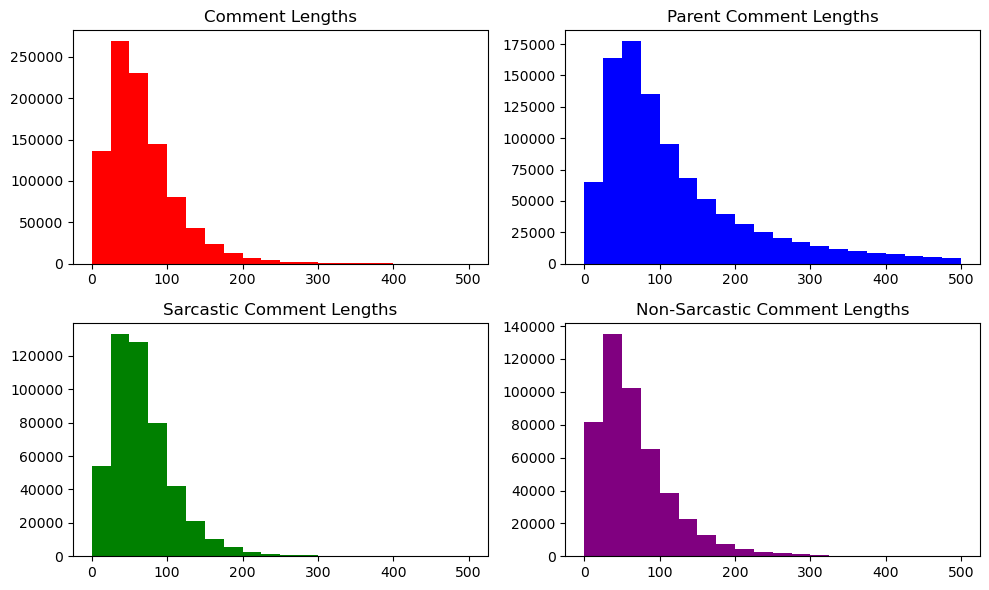

In [16]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 6))

ax1.hist(data['comment_length'], 20, range=[0, 500], color="red")
ax1.title.set_text("Comment Lengths")
ax2.hist(data['parent_length'], 20, range=[0, 500], color="blue")
ax2.title.set_text("Parent Comment Lengths")
ax3.hist(sarcastic_df['comment_length'], 20, range=[0, 500], color="green")
ax3.title.set_text("Sarcastic Comment Lengths")
ax4.hist(non_sarcastic_df['comment_length'], 20, range=[0, 500], color="purple")
ax4.title.set_text("Non-Sarcastic Comment Lengths")

fig.tight_layout()
fig.show()

## Top words

In [17]:
sarc_comments = [text.split() for text in sarcastic_df['comment'].tolist()]
nsarc_comments = [text.split() for text in non_sarcastic_df['comment'].tolist()]

sarc_comments = list(chain.from_iterable(sarc_comments))
nsarc_comments = list(chain.from_iterable(nsarc_comments))

In [18]:
exclude_words = {placeholder[1:-1] for placeholder in punc_inplace.values()}
exclude_words = exclude_words.union(set(STOPWORDS))

sarc_comments = [token for token in sarc_comments if token not in exclude_words]
nsarc_comments = [token for token in nsarc_comments if token not in exclude_words]

In [19]:
print("Most popular in sarcastic:")
print([x[0] for x in Counter(sarc_comments).most_common(20)])
print("Most popular in non-sarcastic: ")
print([x[0] for x in Counter(nsarc_comments).most_common(20)])

Most popular in sarcastic:
['yeah', 'will', 'people', 'well', 'right', 'know', 'one', 'good', 'sure', 'yes', 'us', 'now', 'oh', 'think', 'obviously', 'really', 'make', 'see', 'man', 'never']
Most popular in non-sarcastic: 
['will', 'one', 'think', 'people', 'know', 'well', 'good', 'really', 'time', 'going', 'now', 'yeah', 'even', 'still', 'see', 'got', 'make', 'right', 'much', 'want']


## Wordclouds

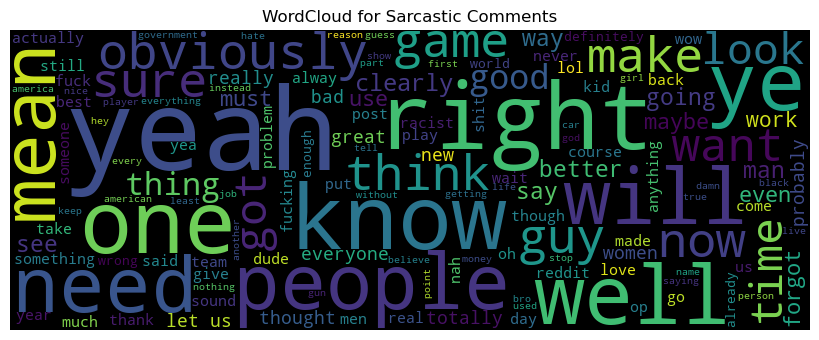

In [20]:
wordcloud = WordCloud(width = 800, height = 300,
                background_color ='black',
                min_font_size = 10).generate(" ".join([w for w in sarc_comments]))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title("WordCloud for Sarcastic Comments")
plt.tight_layout(pad = 0)
 
plt.show()

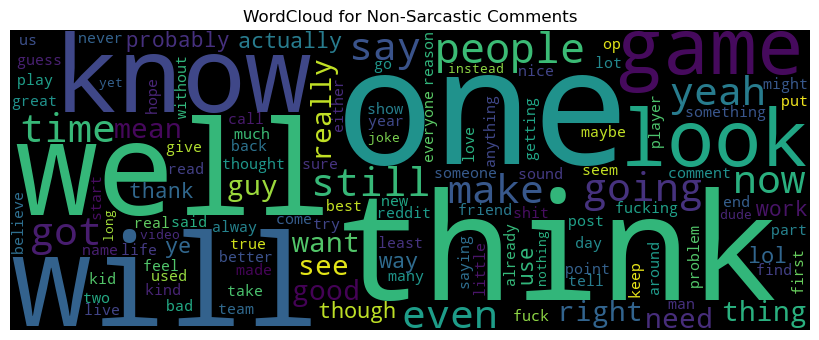

In [21]:
wordcloud = WordCloud(width = 800, height = 300,
                background_color ='black',
                min_font_size = 10).generate(" ".join([w for w in nsarc_comments]))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title("WordCloud for Non-Sarcastic Comments")
plt.tight_layout(pad = 0)
 
plt.show()